In [3]:
import pickle 
from yamlParseObjects.yamlObjects import * 
from yamlParseObjects.variablesUtil import *
from ActiveLearning.benchmarks import SineFunc
from ActiveLearning.Sampling import *
import platform
import shutil
import matplotlib.pyplot as plt 
from ActiveLearning.optimizationHelper import GA_Optimizer, GA_Convergence_Sampler, GA_Exploiter, GA_Voronoi_Explorer, ResourceAllocator
from copy import copy, deepcopy
from geneticalgorithm import geneticalgorithm as ga 
from ActiveLearning.visualization import *
import time 
from datetime import datetime 
import numpy as np 
import heapq
from collections import defaultdict 

# Context 

This is the first example of the convergence sampling after the progress on the conventional exploitation sampling has hit its llimits.

Points: 
- The sampling goes on for 20 iterations without any check on the advancement of the algorithm.
- A Cache is built into the sampler so that each individual SV can only be selected by the algorithm twice in the whole process. 
- The benchmark changes based on what was done for the original process. The benchmark is then loaded from a pickle that was saved for each iteration of that process. 
- The cache only uses 6 digits of each dimension of the SV when looking in the hash table. The reason for that was the floating point error that could result in cache miss and waste of resources. 


In [11]:
# Loading the data related to the experiment: 
pickleName = 'results_outcome_35'
outputLoc = 'C:/Users/Behshad/Google Drive/codes/ScenarioGenerator/assets/outputReports/130'
pickleLoc = f'{outputLoc}/{pickleName}.pickle'
metricLoc= f'{outputLoc}/data/metrics.pickle'
plotFigures = False 
sampleNumber = 100

In [12]:
with open(pickleLoc, 'rb') as pickleIn:
    data = pickle.load(pickleIn)
    print(data)

with open(metricLoc, 'rb') as metricsIn:
    metricData = pickle.load(metricsIn)
    print(metricData)    

{'clf': StandardClassifier(C=1000), 'space': <ActiveLearning.Sampling.SampleSpace object at 0x00000284A0861B08>, 'benchmark': <ActiveLearning.benchmarks.SineFunc object at 0x00000284A0799848>}


C:\Python\Python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


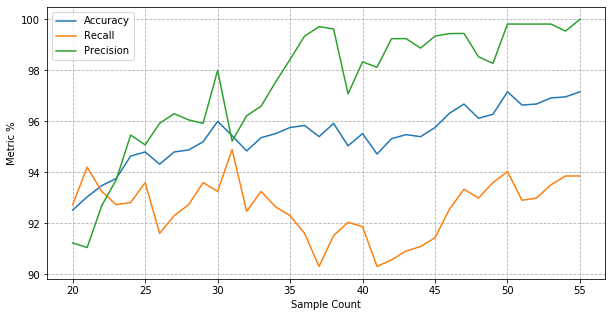

In [13]:
plt.figure(figsize = (10,5))
plt.plot(metricData.sampleCount, metricData.acc, label='Accuracy')
plt.grid(b=True, which = 'both', linestyle = '--')
plt.plot(metricData.sampleCount, metricData.recall, label = 'Recall')
plt.plot(metricData.sampleCount, metricData.precision, label = 'Precision')
plt.xlabel('Sample Count')
plt.ylabel('Metric %')
plt.legend()

[-1, 0, 1] ['k', 'k', 'k'] ['dashed', 'solid', 'dotted']


C:\Python\Python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


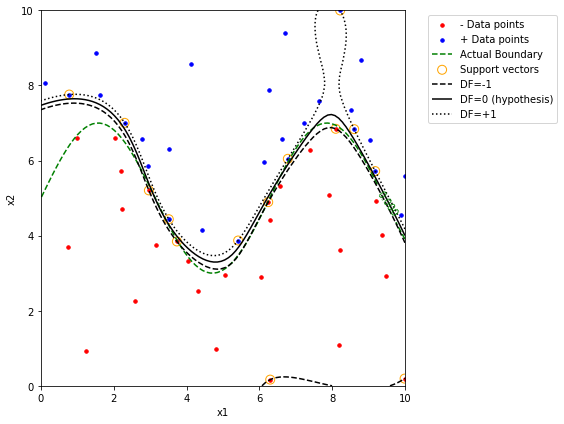

In [15]:
data = [] 
with open(pickleLoc, 'rb') as pickleIn:
    data = pickle.load(pickleIn)
 
mySpace = data['space']
clf = data['clf']
myBench = data['benchmark']
meshRes = 100
figSize = (8,6)
plotSpace(mySpace, 
        classifier=clf, 
        figsize = figSize, 
        meshRes=meshRes,
        gridRes = (6,6),
        legend = True, 
        showPlot=True, 
        benchmark = myBench)

In [16]:
# Defining the sample that is used for checking the progeress as well as the performance metrics of the process:
convSample = ConvergenceSample(mySpace)
accuracy = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.ACCURACY)
precision = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.PRECISION)
recall = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.RECALL)
print(accuracy, precision, recall) 

acc = [accuracy]
prec = [precision]
rec = [recall]
sampleCount = [mySpace.sampleNum]

Generating the samples using Halton sequences method. This may take a while...
97.16 100.0 93.85813148788927


# The prototype of the convergance sampler

This class provides the necessary functionalities that are needed to perform the convergence sampling with Idea III. These are the steps:
1. Find the support vector with the largest distance to the closest sample of the opposite class.
2. Get the mid point between that SV and its neighbor of the opposite class. 
3. calculate the decision function of the current classifier at the mid point as $\hat{f} = f(x_{mid})$ 
4. Sample on the $f(x)=\hat{f}$ curve while maximizing the distance to evaluated samples. This step is similar to the conventional exploitation sampling but instead of sampling on the boundary which is the $f(x)=0$ curve, we are sampling on $f(x)=C$, where $C$ is determined by the previous step. 
5. Note the Support vector that was used for the process. If the support vector is selected twice, it cannot be selected for process anymore. This is to avoid getting stuck in a non-beneficial sampling sequence where an irrelevant SV is selected each time without any change to the actual boundary. 

In [17]:
class Converger_III(GA_Optimizer):
    def __init__(self, 
                space: SampleSpace,
                clf: StandardClassifier,
                epsilon:float,  
                batchSize: int = 1, 
                convergence_curve=True, 
                progress_bar=True, 
                constraints=[]):
        GA_Optimizer.__init__(self, 
                        space, 
                        batchSize=batchSize, 
                        convergence_curve=convergence_curve, 
                        progress_bar=progress_bar, 
                        constraints=constraints)
        self.clf = clf  
        self.epsilon = epsilon
        self.ranges = space.getAllDimensionsRanges()
        self.foundSvs = set()
        # Counts the number of times each SV is used in the process:
        self.counts = defaultdict(int)

    def _minDistanceFromOppClass(self, point, label):
        space = self.space
        opLabel = label ^ 1 
        ranges = space.getAllDimensionsRanges()
        labels = np.array(space._eval_labels)
        oppSamples = space.samples[labels==opLabel,:]
        distances = np.linalg.norm(np.divide(oppSamples-point, ranges), axis = 1)
        distInd = np.argmin(distances)
        closestSample = oppSamples[distInd, :]
        distance = distances[distInd]
        return distance, closestSample
    
    def _updateBounds(self):
        ranges = self.space.getAllDimensionsRanges()
        initialBounds = self.space.getAllDimensionBounds()
        bounds = np.zeros(shape = (len(ranges),2)) 
        for ind,d in enumerate(self.sv):
            bounds[ind,0] = max(initialBounds[ind,0], d - R * ranges[ind])
            bounds[ind,1] = min(initialBounds[ind,1], d + R * ranges[ind])
        self.bounds= bounds 


    def getFittingSupportVector(self):
        # No support for batch sampling is considered yet. 
        SVs = self.clf.getSupportVectors(standard = True)
        labels = self.clf.predict(SVs)
        maxDist = float('-inf')
        candidSV, candidCp, candidLabel = None, None, None 
        R = 0
        for idx , sv in enumerate(SVs):
            label = labels[idx]
            svDist, svCp = self._minDistanceFromOppClass(sv, label)
            if svDist > maxDist: 
                candidSV = sv 
                candidCp = svCp 
                R = svDist / 2 
                candidLabel = label 
                maxDist = svDist
        return candidSV, candidCp, candidLabel, R 
    
    def getFittingSupportVectorUnique(self, addToFound = False ):
        SVs = self.clf.getSupportVectors(standard = True)
        labels = self.clf.predict(SVs)
        maxDist = float('-inf')
        candidSV, candidCp, candidLabel = None, None, None 
        R = 0
        for idx , sv in enumerate(SVs):
            label = labels[idx]
            svDist, svCp = self._minDistanceFromOppClass(sv, label)
            tupSv = self.roundSV(sv)
            if svDist > maxDist and self.counts[tupSv] < 2: 
                candidSV = sv 
                candidCp = svCp 
                R = svDist * 2/3 
                candidLabel = label 
                maxDist = svDist
        if addToFound:
            # Incrementing the number of times we have seen the same SV. Each SV can be senected twice only! 
            self.counts[self.roundSV(candidSV)] += 1 
        print('Found SV:', candidSV)
        return candidSV, candidCp, candidLabel, R 

    def roundSV(self, sv, n = 6):
        return tuple([round(svEl, n) for svEl in sv])

    def findNextPoints(self, pointNum = 1, tries = 3):
        self.sv, self.cp, self.label, self.R = self.getFittingSupportVectorUnique(addToFound=True)
        midPoint = (self.sv+self.cp)/2
        midPoint = midPoint.reshape(1,len(midPoint))
        self.decisionFunction = self.clf.decision_function(midPoint)
        # Bounds for the GA model will be updated after the SV is found:
        self._updateBounds() 
        return super().findNextPoints(pointNum = pointNum, tries = tries)
    
    
    def objFunction(self, X):
        dist = self.space.nearestPointDistance(X, self.currentSpaceSamples, normalize=True)
        pen = 0
        df = self.clf.decision_function(X.reshape(1,len(X)))
        xScaled = self.clf.scaler.transform(X.reshape(1,len(X)))
        svScaled = self.clf.scaler.transform(self.sv.reshape(1,len(self.sv)))
        svDist = np.linalg.norm(xScaled - svScaled)
        if abs(df - self.decisionFunction) > self.epsilon or svDist > self.R:
            pen = 1e6
        return -1 * dist + pen 

# Adding the new sample to the sample space and retraining the classifier

Here we add the sample that we got wit it label that we got from the benchmark object to the sample space. The classifier is trained again to reflect the effect of the new sample. 
We need to update the classifier that is assigned to the converger for the next point. 

98.1168 98.56851696439276 98.60871233928229
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {})
Found SV: [-6.08655083 -2.44066334 -3.49756992  9.51274385]
Radius: 0.17969168214033573
Found SV: [-6.08655083 -2.44066334 -3.49756992  9.51274385]
 The best solution found:
 [-6.33501914 -2.00118087 -6.9030429   9.83664076]

 Objective function:
 -0.15136863770174325


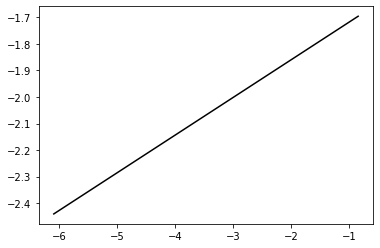

Sample Count:425, New Samples:1, Accuracy:98.11999999999999, Precision: 98.50578290749743, Recall:98.67827672231817
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 0, (1.497923, -9.477612, -0.834146, 4.979406): 0, (-6.086551, -2.440663, -3.49757, 9.512744): 1})
Found SV: [ 1.49792255 -9.47761229 -0.83414593  4.97940563]
Radius: 0.17807904722826443
Found SV: [ 1.49792255 -9.47761229 -0.83414593  4.97940563]
 The best solution found:
 [ 4.75324857 -9.70817849  0.21517478  5.16550744]

 Objective function:
 -0.17165383841186596


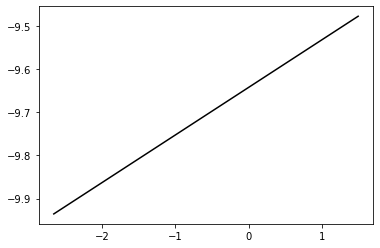

Sample Count:426, New Samples:2, Accuracy:98.11999999999999, Precision: 98.50578290749743, Recall:98.67827672231817
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 0, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 0})
Found SV: [ 8.42584476 -0.61070275 -9.87245348  9.58322913]
Radius: 0.1758765376917231
Found SV: [ 8.42584476 -0.61070275 -9.87245348  9.58322913]
 The best solution found:
 [ 7.38079037 -0.37815692 -6.83113008  8.54447258]

 Objective function:
 -0.14920279038584958


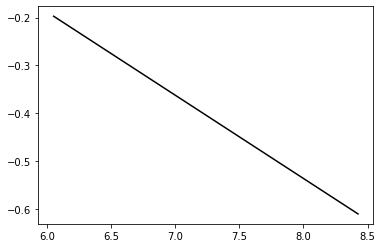

Sample Count:427, New Samples:3, Accuracy:98.112, Precision: 98.5079273842027, Recall:98.66388409134524
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 0, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1})
Found SV: [ 9.65485957  5.8960144   9.92194881 -6.93892274]
Radius: 0.16834041281145898
Found SV: [ 9.65485957  5.8960144   9.92194881 -6.93892274]
 The best solution found:
 [ 9.82938418  3.44386158  9.52574456 -5.91813828]

 Objective function:
 -0.12107258749020493


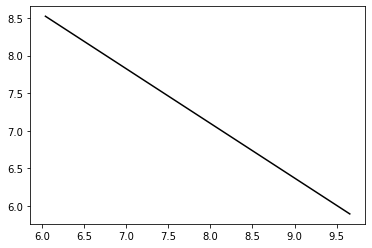

Sample Count:428, New Samples:4, Accuracy:98.112, Precision: 98.51025100593984, Recall:98.6614853195164
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1})
Found SV: [ 9.82938418  3.44386158  9.52574456 -5.91813828]
Radius: 0.19261626493984899
Found SV: [ 9.82938418  3.44386158  9.52574456 -5.91813828]
 The best solution found:
 [ 9.6106099   0.28459849  7.90852459 -6.92296333]

 Objective function:
 -0.16438652138144402


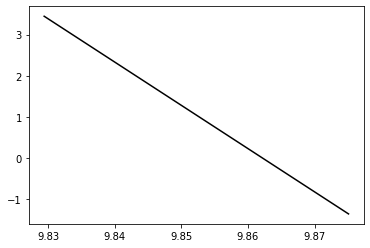

Sample Count:429, New Samples:5, Accuracy:98.1104, Precision: 98.5078916485043, Recall:98.6614853195164
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 0, (9.829384, 3.443862, 9.525745, -5.918138): 1})
Found SV: [ 9.99457362 -9.8876901  -8.73768074 -9.38394785]
Radius: 0.16479622966227525
Found SV: [ 9.99457362 -9.8876901  -8.73768074 -9.38394785]
 The best solution found:
 [ 9.94073816 -7.17687333 -7.83467191 -8.43754753]

 Objective function:
 -0.15052013404883477


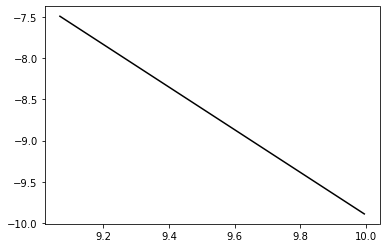

Sample Count:430, New Samples:6, Accuracy:98.1584, Precision: 98.54846822678387, Recall:98.69266935329112
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 0, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1})
Found SV: [ 7.38079037 -0.37815692 -6.83113008  8.54447258]
Radius: 0.15784303676615577
Found SV: [ 7.38079037 -0.37815692 -6.83113008  8.54447258]
 The best solution found:
 [ 4.65939608 -0.29151066 -7.34400202  9.9581057 ]

 Objective function:
 -0.15552243103612168


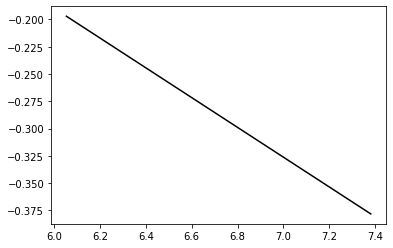

Sample Count:431, New Samples:7, Accuracy:98.112, Precision: 98.5497866628314, Recall:98.6207061984264
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1})
Found SV: [ 6.05410697 -0.19705598 -9.541688    4.89989151]
Radius: 0.15784303676615574
Found SV: [ 6.05410697 -0.19705598 -9.541688    4.89989151]
 The best solution found:
 [ 5.76641144 -0.53352287 -9.78879661  7.89210767]

 Objective function:
 -0.15174319507750353


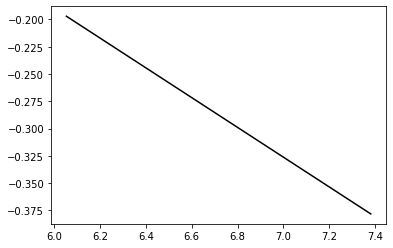

Sample Count:432, New Samples:8, Accuracy:98.128, Precision: 98.54780733285406, Recall:98.64709268854347
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1})
Found SV: [ 7.90319831  8.55804867 -4.47813681 -9.25813521]
Radius: 0.15732464272268745
Found SV: [ 7.90319831  8.55804867 -4.47813681 -9.25813521]
 The best solution found:
 [ 5.24484357  8.48054762 -3.67834836 -8.31793847]

 Objective function:
 -0.14635388569721888


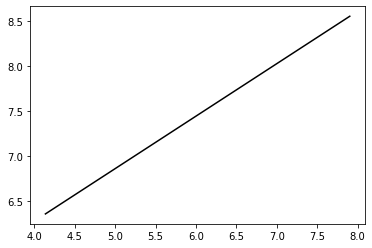

Sample Count:433, New Samples:9, Accuracy:98.128, Precision: 98.54780733285406, Recall:98.64709268854347
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 0, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1})
Found SV: [ 0.2048223  -1.65652208  9.86571425 -8.82253476]
Radius: 0.1570293288494408
Found SV: [ 0.2048223  -1.65652208  9.86571425 -8.82253476]
 The best solution found:
 [ 1.49828928 -1.47174996  7.99003454 -6.67500108]

 Objective function:
 -0

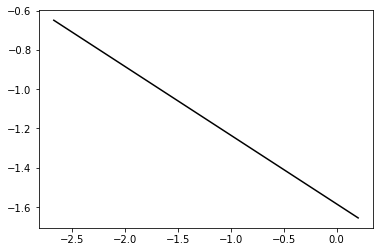

Sample Count:434, New Samples:10, Accuracy:98.10560000000001, Precision: 98.58925143953935, Recall:98.5703319900211
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1})
Found SV: [-9.75707969  5.46002153 -2.79866974  4.87160426]
Radius: 0.15597454544312303
Found SV: [-9.75707969  5.46002153 -2.79866974  4.87160426]
 The best solution found:
 [-9.76169864  8.37236231 -2.58862749  5.31425262]

 Objective f

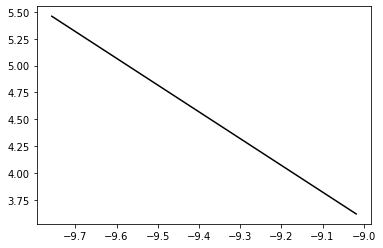

Sample Count:435, New Samples:11, Accuracy:98.1328, Precision: 98.62014350507548, Recall:98.57992707733641
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1})
Found SV: [-7.53502836 -6.41282847  2.60851227  4.19821026]
Radius: 0.15412171178254475
Found SV: [-7.53502836 -6.41282847  2.60851227  4.19821026]
 The best solution found:
 [-6.45629266 -4.51287912  1

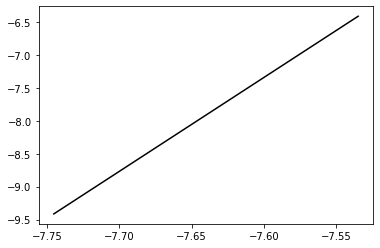

Sample Count:436, New Samples:12, Accuracy:98.1296, Precision: 98.62007727567256, Recall:98.57512953367875
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1})
Found SV: [ 9.4387999   9.85323411  9.42099156 -7.88423713]
Ra

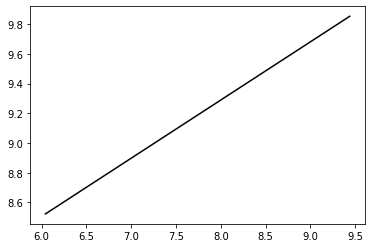

Sample Count:437, New Samples:13, Accuracy:98.1648, Precision: 98.62313799803304, Recall:98.62550374208405
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

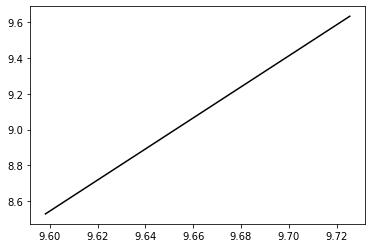

Sample Count:438, New Samples:14, Accuracy:98.1648, Precision: 98.62313799803304, Recall:98.62550374208405
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

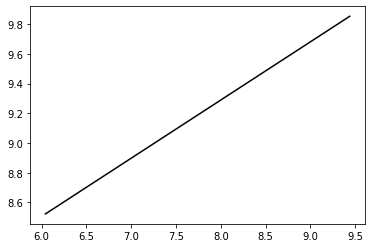

Sample Count:439, New Samples:15, Accuracy:98.2096, Precision: 98.6847473898956, Recall:98.6303012857417
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.10360

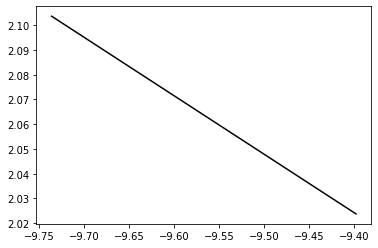

Sample Count:440, New Samples:16, Accuracy:98.2064, Precision: 98.68234729389175, Recall:98.62790251391289
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

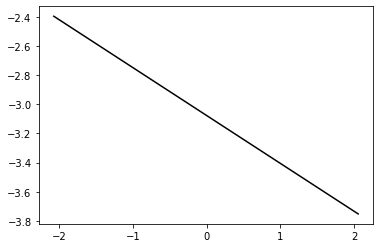

Sample Count:441, New Samples:17, Accuracy:98.2576, Precision: 98.61107785148113, Recall:98.77902513912876
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

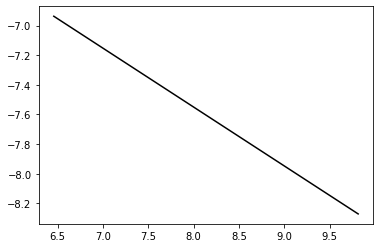

Sample Count:442, New Samples:18, Accuracy:98.3184, Precision: 98.6495869747396, Recall:98.83179811936289
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.1036

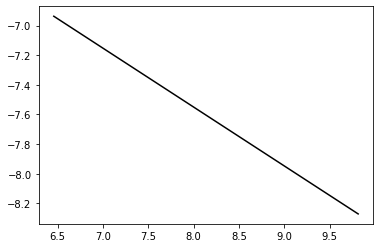

Sample Count:443, New Samples:19, Accuracy:98.22720000000001, Precision: 98.64774144049103, Recall:98.69506812511993
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736

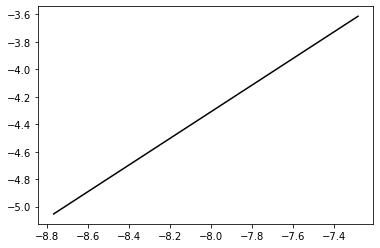

Sample Count:444, New Samples:20, Accuracy:98.2384, Precision: 98.66896899057485, Recall:98.69027058146229
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

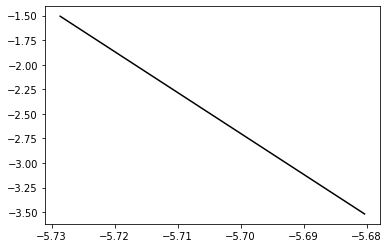

Sample Count:445, New Samples:21, Accuracy:98.2352, Precision: 98.66890514450174, Recall:98.68547303780464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

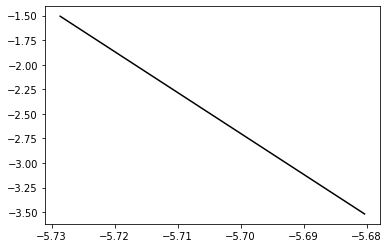

Sample Count:446, New Samples:22, Accuracy:98.2448, Precision: 98.68077043006885, Recall:98.68787180963346
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

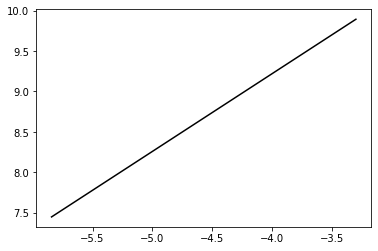

Sample Count:447, New Samples:23, Accuracy:98.3536, Precision: 98.81618441589627, Recall:98.71425829975053
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

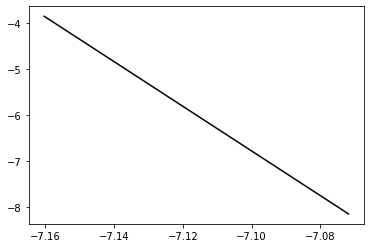

Sample Count:448, New Samples:24, Accuracy:98.3536, Precision: 98.81618441589627, Recall:98.71425829975053
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

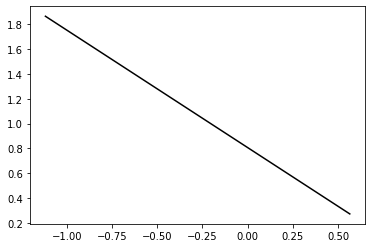

Sample Count:449, New Samples:25, Accuracy:98.3056, Precision: 98.81533101045297, Recall:98.64229514488582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

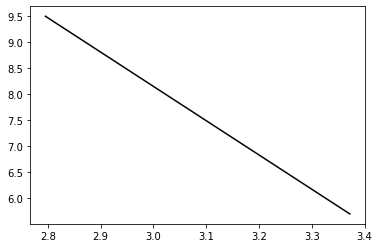

Sample Count:450, New Samples:26, Accuracy:98.3056, Precision: 98.81533101045297, Recall:98.64229514488582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

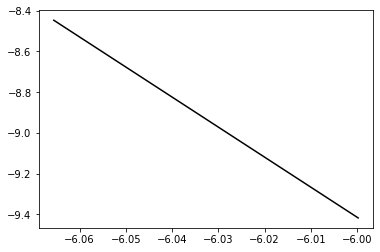

Sample Count:451, New Samples:27, Accuracy:98.3056, Precision: 98.81533101045297, Recall:98.64229514488582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.103

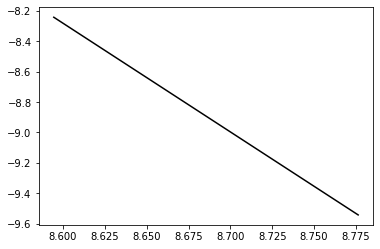

Sample Count:452, New Samples:28, Accuracy:98.312, Precision: 98.81309915667572, Recall:98.65428900402993
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 0, (-9.736364, 2.1036

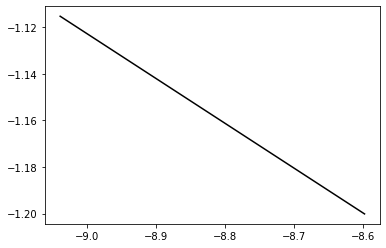

Sample Count:453, New Samples:29, Accuracy:98.3168, Precision: 98.80380476556495, Recall:98.6710804068317
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

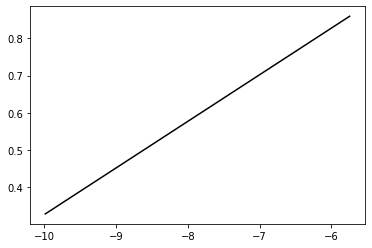

Sample Count:454, New Samples:30, Accuracy:98.3184, Precision: 98.80383349746596, Recall:98.67347917866053
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

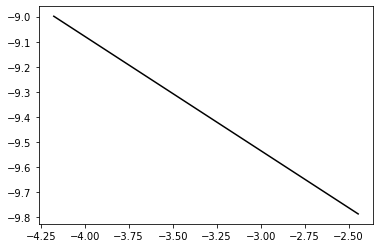

Sample Count:455, New Samples:31, Accuracy:98.3168, Precision: 98.80380476556495, Recall:98.6710804068317
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

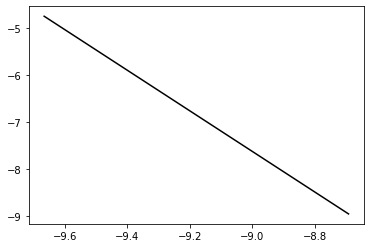

Sample Count:456, New Samples:32, Accuracy:98.28320000000001, Precision: 98.74930983988286, Recall:98.67587795048935
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

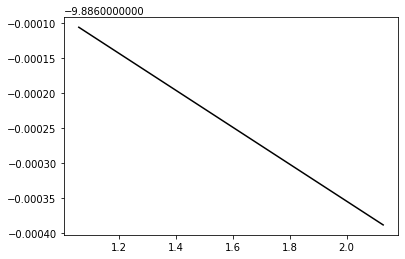

Sample Count:457, New Samples:33, Accuracy:98.2816, Precision: 98.7492798156328, Recall:98.67347917866053
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 0, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

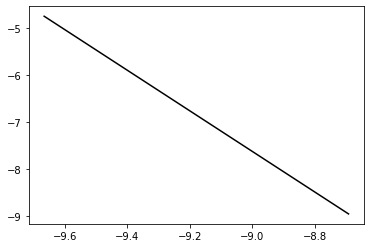

Sample Count:458, New Samples:34, Accuracy:98.3168, Precision: 98.79208491426925, Recall:98.68307426597582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 1, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

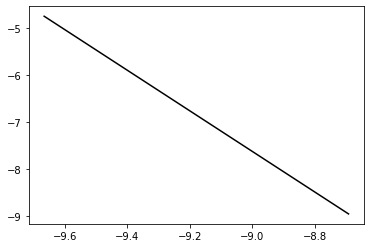

Sample Count:459, New Samples:35, Accuracy:98.3216, Precision: 98.77343318691342, Recall:98.70946075609288
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

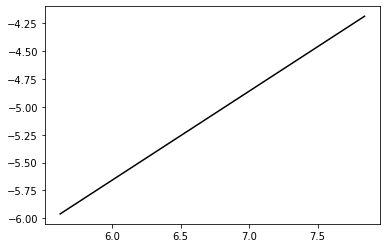

Sample Count:460, New Samples:36, Accuracy:98.3584, Precision: 98.83033912959938, Recall:98.70706198426406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

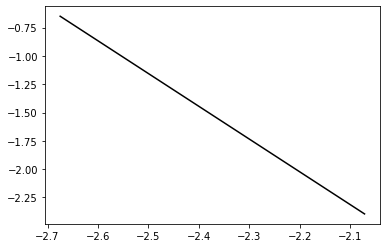

Sample Count:461, New Samples:37, Accuracy:98.3728, Precision: 98.84232016332413, Recall:98.71665707157935
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

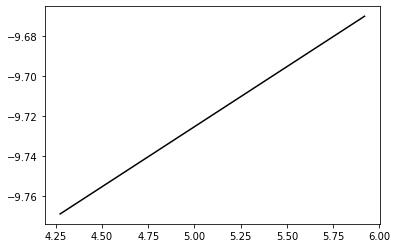

Sample Count:462, New Samples:38, Accuracy:98.3712, Precision: 98.83994620040349, Recall:98.71665707157935
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

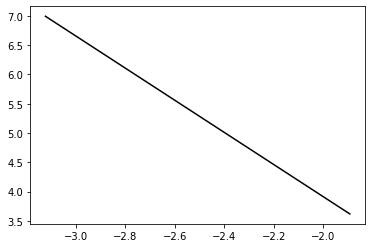

Sample Count:463, New Samples:39, Accuracy:98.2992, Precision: 98.76365382307046, Recall:98.68547303780464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

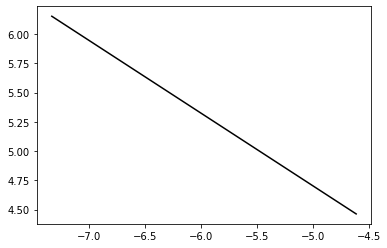

Sample Count:464, New Samples:40, Accuracy:98.3008, Precision: 98.76368350297676, Recall:98.68787180963346
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

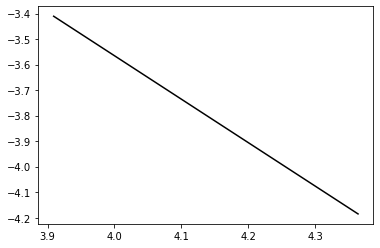

Sample Count:465, New Samples:41, Accuracy:98.3008, Precision: 98.76602487156096, Recall:98.68547303780464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

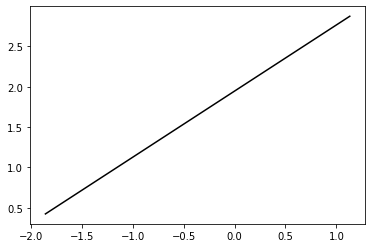

Sample Count:466, New Samples:42, Accuracy:98.3024, Precision: 98.76839603389912, Recall:98.68547303780464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

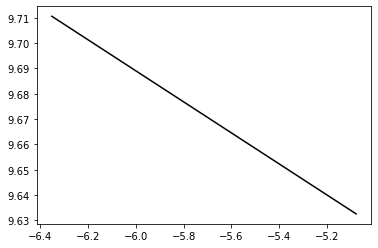

Sample Count:467, New Samples:43, Accuracy:98.3024, Precision: 98.76839603389912, Recall:98.68547303780464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

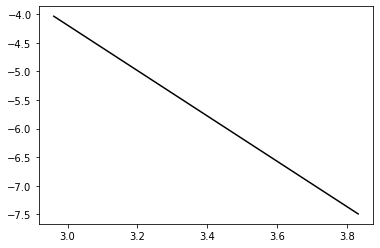

Sample Count:468, New Samples:44, Accuracy:98.3024, Precision: 98.74733027765113, Recall:98.70706198426406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

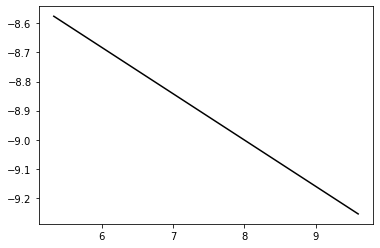

Sample Count:469, New Samples:45, Accuracy:98.3024, Precision: 98.74733027765113, Recall:98.70706198426406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

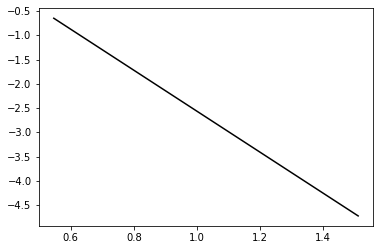

Sample Count:470, New Samples:46, Accuracy:98.304, Precision: 98.74970002399807, Recall:98.70706198426406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

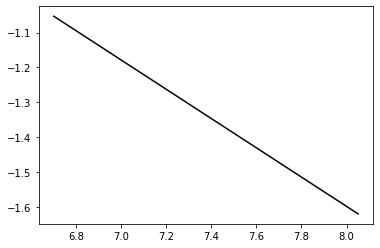

Sample Count:471, New Samples:47, Accuracy:98.264, Precision: 98.7091820821037, Recall:98.68787180963346
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.10360

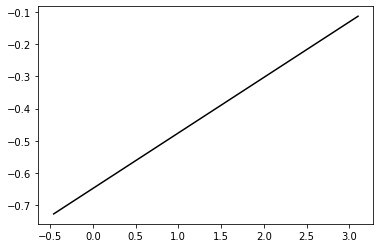

Sample Count:472, New Samples:48, Accuracy:98.23039999999999, Precision: 98.7015168970814, Recall:98.64469391671464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 1, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.7363

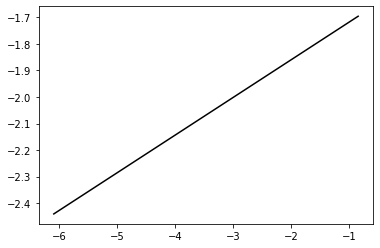

Sample Count:473, New Samples:49, Accuracy:98.22720000000001, Precision: 98.70145456291105, Recall:98.63989637305698
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

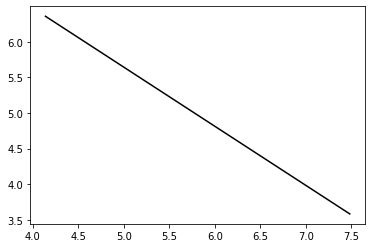

Sample Count:474, New Samples:50, Accuracy:98.2288, Precision: 98.70382372002592, Recall:98.63989637305698
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

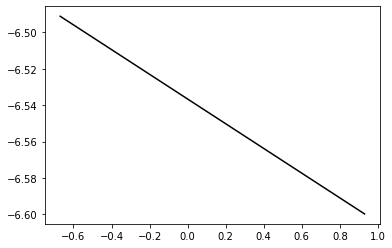

Sample Count:475, New Samples:51, Accuracy:98.1888, Precision: 98.61896998177806, Recall:98.66628286317406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

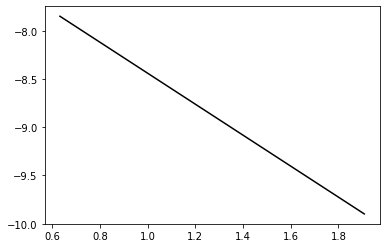

Sample Count:476, New Samples:52, Accuracy:98.1888, Precision: 98.61896998177806, Recall:98.66628286317406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

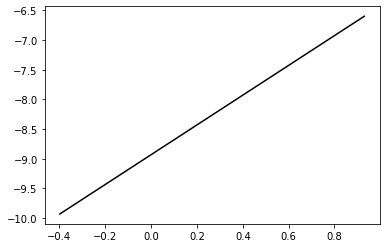

Sample Count:477, New Samples:53, Accuracy:98.2336, Precision: 98.63154867468724, Recall:98.72145461523701
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

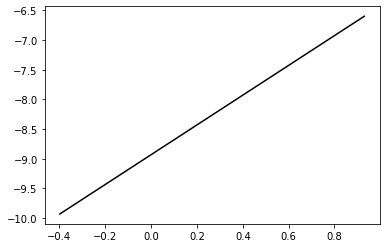

Sample Count:478, New Samples:54, Accuracy:98.2176, Precision: 98.63355228460469, Recall:98.69506812511993
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

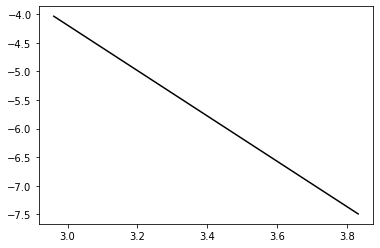

Sample Count:479, New Samples:55, Accuracy:98.2368, Precision: 98.61996262398773, Recall:98.73824601803877
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

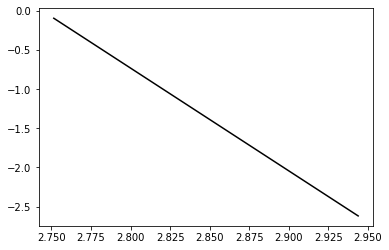

Sample Count:480, New Samples:56, Accuracy:98.2528, Precision: 98.63194211509895, Recall:98.75023987718288
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

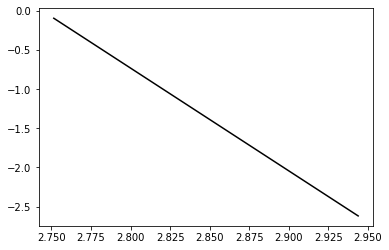

Sample Count:481, New Samples:57, Accuracy:98.256, Precision: 98.6343380133212, Recall:98.7526386490117
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103608

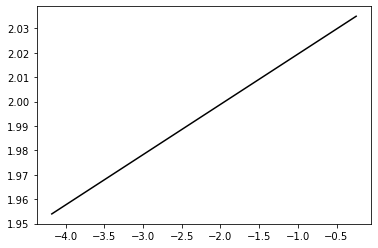

Sample Count:482, New Samples:58, Accuracy:98.2496, Precision: 98.6295462168767, Recall:98.74784110535406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

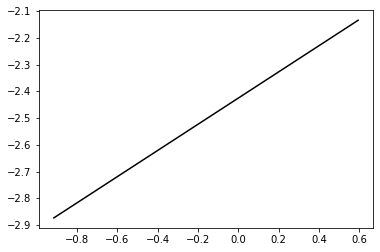

Sample Count:483, New Samples:59, Accuracy:98.2688, Precision: 98.62761065338186, Recall:98.77902513912876
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

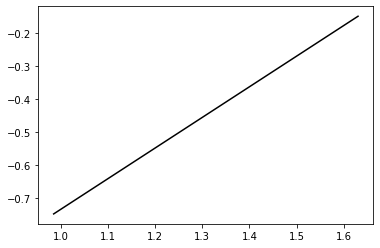

Sample Count:484, New Samples:60, Accuracy:98.2288, Precision: 98.66644280814525, Recall:98.67827672231817
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

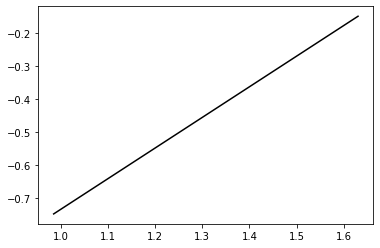

Sample Count:485, New Samples:61, Accuracy:98.1856, Precision: 98.65623650237558, Recall:98.62310497025523
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

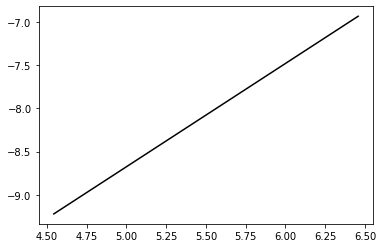

Sample Count:486, New Samples:62, Accuracy:98.1712, Precision: 98.66295398353297, Recall:98.59431970830934
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

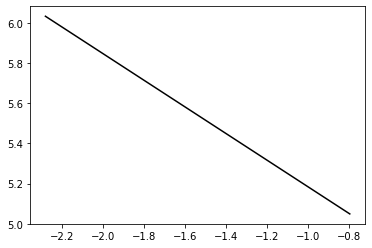

Sample Count:487, New Samples:63, Accuracy:98.1568, Precision: 98.62297284329719, Recall:98.61350988293994
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

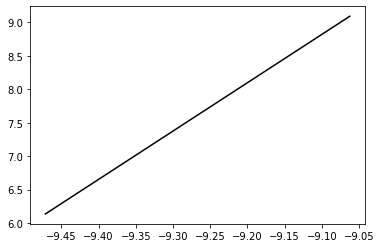

Sample Count:488, New Samples:64, Accuracy:98.1568, Precision: 98.62297284329719, Recall:98.61350988293994
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

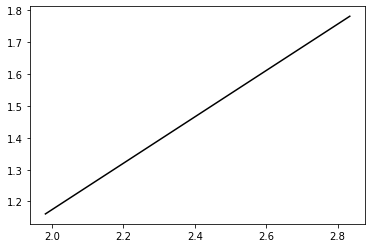

Sample Count:489, New Samples:65, Accuracy:98.2176, Precision: 98.6849052075834, Recall:98.64229514488582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

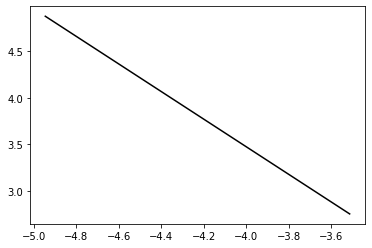

Sample Count:490, New Samples:66, Accuracy:98.2432, Precision: 98.72515125324114, Recall:98.63989637305698
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

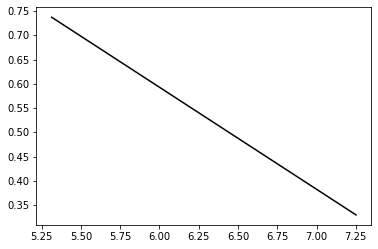

Sample Count:491, New Samples:67, Accuracy:98.2336, Precision: 98.7202881152461, Recall:98.6303012857417
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.10360

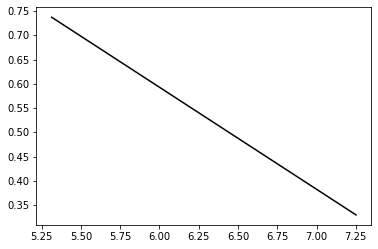

Sample Count:492, New Samples:68, Accuracy:98.2176, Precision: 98.7223209568183, Recall:98.60391479562463
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

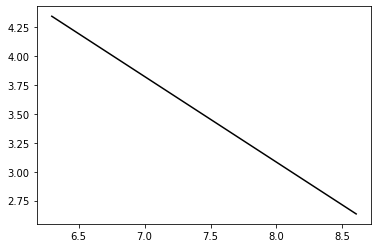

Sample Count:493, New Samples:69, Accuracy:98.21600000000001, Precision: 98.7199500468311, Recall:98.60391479562463
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.7363

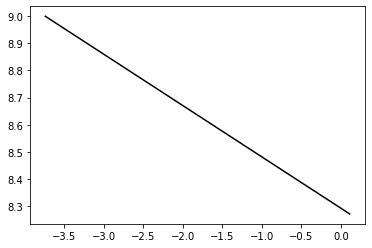

Sample Count:494, New Samples:70, Accuracy:98.26559999999999, Precision: 98.75600384245917, Recall:98.64229514488582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

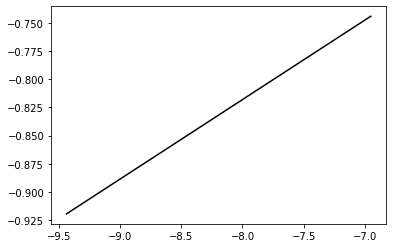

Sample Count:495, New Samples:71, Accuracy:98.2784, Precision: 98.75156054931335, Recall:98.66628286317406
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

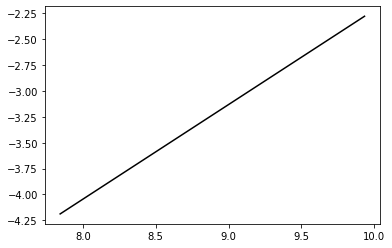

Sample Count:496, New Samples:72, Accuracy:98.2448, Precision: 98.76498714529421, Recall:98.60151602379582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

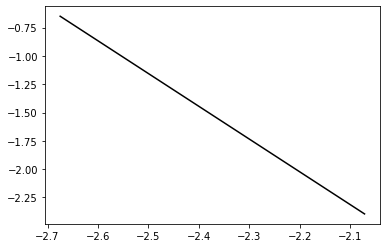

Sample Count:497, New Samples:73, Accuracy:98.2448, Precision: 98.76498714529421, Recall:98.60151602379582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

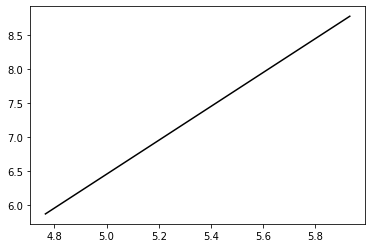

Sample Count:498, New Samples:74, Accuracy:98.2384, Precision: 98.73442040296823, Recall:98.62310497025523
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

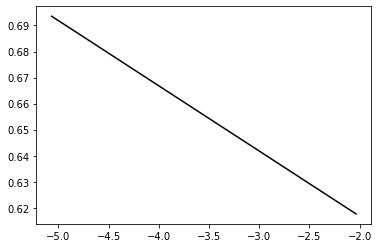

Sample Count:499, New Samples:75, Accuracy:98.2624, Precision: 98.75360230547551, Recall:98.63989637305698
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

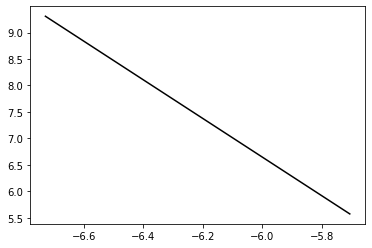

Sample Count:500, New Samples:76, Accuracy:98.2544, Precision: 98.6739563100976, Recall:98.70946075609288
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

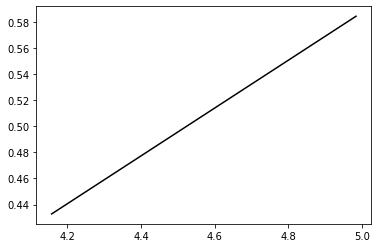

Sample Count:501, New Samples:77, Accuracy:98.21600000000001, Precision: 98.6498477181707, Recall:98.67587795048935
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.7363

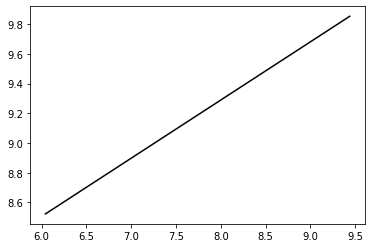

Sample Count:502, New Samples:78, Accuracy:98.24000000000001, Precision: 98.64333652924256, Recall:98.71905584340817
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

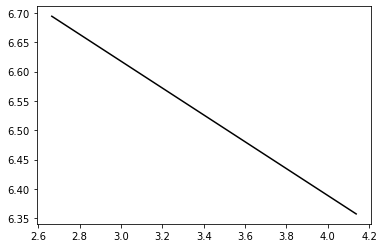

Sample Count:503, New Samples:79, Accuracy:98.2384, Precision: 98.64097217228733, Recall:98.71905584340817
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

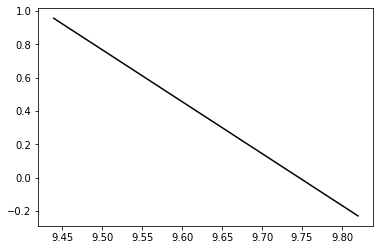

Sample Count:504, New Samples:80, Accuracy:98.24000000000001, Precision: 98.63867318569648, Recall:98.72385338706582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

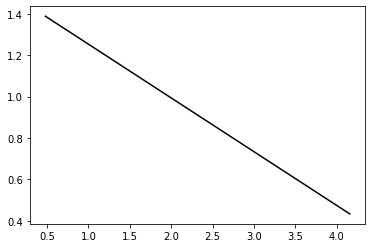

Sample Count:505, New Samples:81, Accuracy:98.256, Precision: 98.66231960492881, Recall:98.72385338706582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

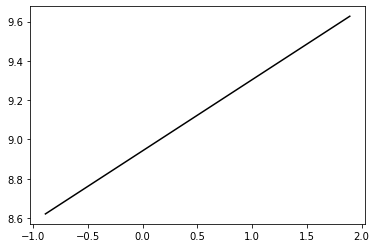

Sample Count:506, New Samples:82, Accuracy:98.288, Precision: 98.73302298795412, Recall:98.69986566877759
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

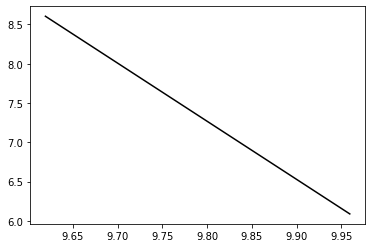

Sample Count:507, New Samples:83, Accuracy:98.2928, Precision: 98.73545290941811, Recall:98.70466321243524
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

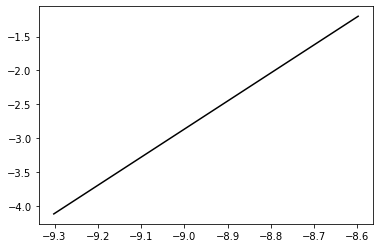

Sample Count:508, New Samples:84, Accuracy:98.2912, Precision: 98.73308378923122, Recall:98.70466321243524
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

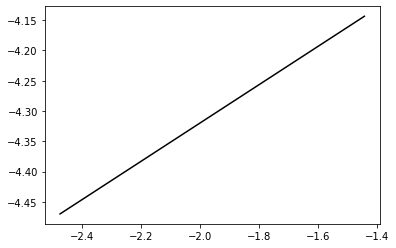

Sample Count:509, New Samples:85, Accuracy:98.304, Precision: 98.75203993472209, Recall:98.70466321243524
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

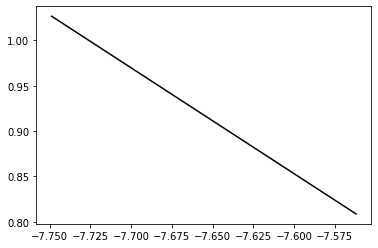

Sample Count:510, New Samples:86, Accuracy:98.2976, Precision: 98.78470554327986, Recall:98.6614853195164
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.1036

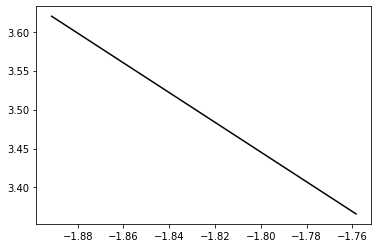

Sample Count:511, New Samples:87, Accuracy:98.2864, Precision: 98.74702959602506, Recall:98.68307426597582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

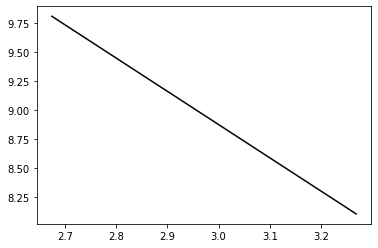

Sample Count:512, New Samples:88, Accuracy:98.2928, Precision: 98.74247042165639, Recall:98.69746689694875
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

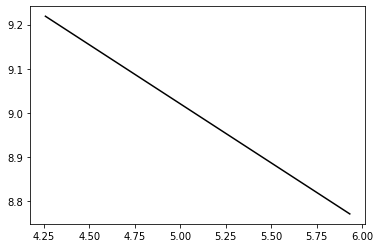

Sample Count:513, New Samples:89, Accuracy:98.2496, Precision: 98.72527367005954, Recall:98.64949146037229
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

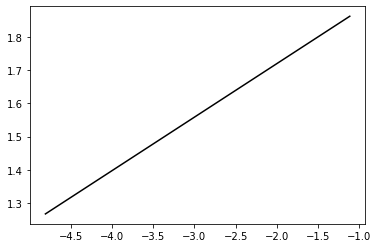

Sample Count:514, New Samples:90, Accuracy:98.1952, Precision: 98.68446322258498, Recall:98.60871233928229
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

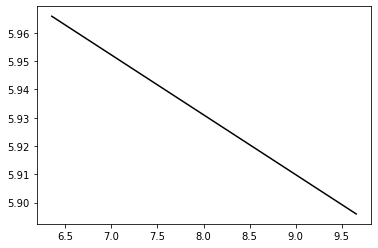

Sample Count:515, New Samples:91, Accuracy:98.1968, Precision: 98.68683231304766, Recall:98.60871233928229
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 0, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

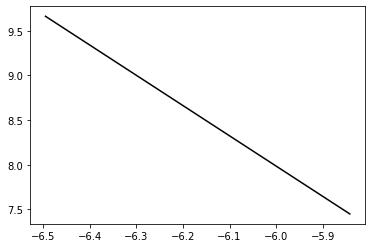

Sample Count:516, New Samples:92, Accuracy:98.1968, Precision: 98.65179321098717, Recall:98.64469391671464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

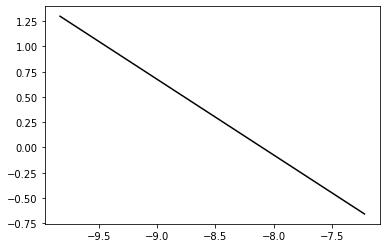

Sample Count:517, New Samples:93, Accuracy:98.1968, Precision: 98.65179321098717, Recall:98.64469391671464
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

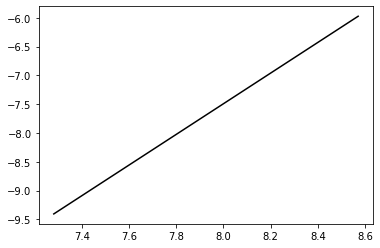

Sample Count:518, New Samples:94, Accuracy:98.17439999999999, Precision: 98.68405254184377, Recall:98.57752830550758
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

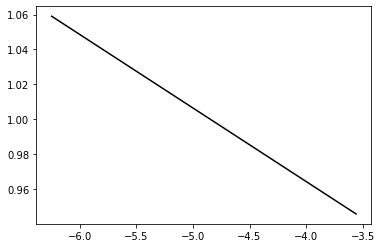

Sample Count:519, New Samples:95, Accuracy:98.17439999999999, Precision: 98.68405254184377, Recall:98.57752830550758
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

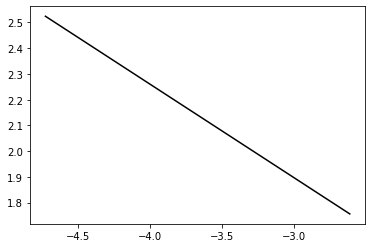

Sample Count:520, New Samples:96, Accuracy:98.17280000000001, Precision: 98.6840209403967, Recall:98.57512953367875
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.7363

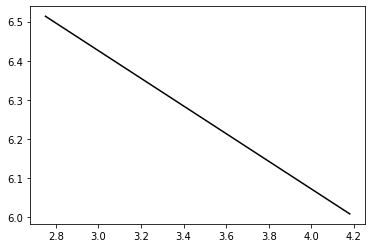

Sample Count:521, New Samples:97, Accuracy:98.2288, Precision: 98.72721596503446, Recall:98.61590865476876
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

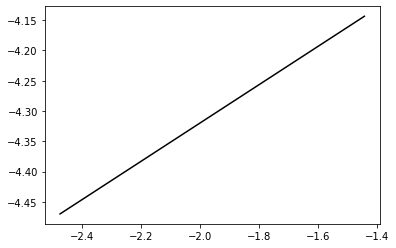

Sample Count:522, New Samples:98, Accuracy:98.25120000000001, Precision: 98.72062600513671, Recall:98.65668777585877
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736

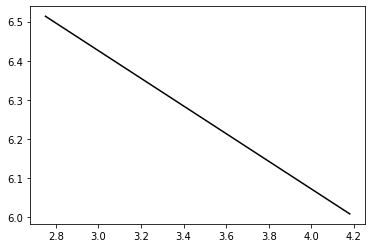

Sample Count:523, New Samples:99, Accuracy:98.2384, Precision: 98.75549575955601, Recall:98.60151602379582
--------------------------------------------------------------------------------------------------------------------------
Found SVs and their counts:  defaultdict(<class 'int'>, {(0.204822, -1.656522, 9.865714, -8.822535): 1, (9.65486, 5.896014, 9.921949, -6.938923): 1, (1.497923, -9.477612, -0.834146, 4.979406): 1, (-6.086551, -2.440663, -3.49757, 9.512744): 2, (8.425845, -0.610703, -9.872453, 9.583229): 1, (7.38079, -0.378157, -6.83113, 8.544473): 1, (9.829384, 3.443862, 9.525745, -5.918138): 1, (9.994574, -9.88769, -8.737681, -9.383948): 1, (6.054107, -0.197056, -9.541688, 4.899892): 1, (7.903198, 8.558049, -4.478137, -9.258135): 1, (-9.75708, 5.460022, -2.79867, 4.871604): 1, (-6.494728, 9.662159, -8.132086, 5.108628): 1, (-9.665637, -4.756611, 6.075258, 6.533167): 2, (-7.535028, -6.412828, 2.608512, 4.19821): 1, (-9.038673, -1.11534, 8.183479, 0.119449): 1, (-9.736364, 2.103

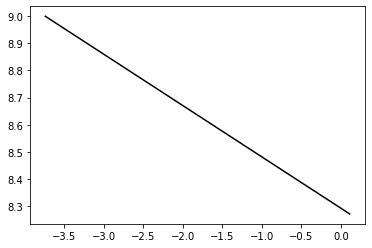

Sample Count:524, New Samples:100, Accuracy:98.2464, Precision: 98.73457234788455, Recall:98.63509882939935


In [57]:
figSize = (14,12)

converger = Converger_III(space= mySpace, clf = clf, epsilon = 0.05, convergence_curve=False, progress_bar=True)
import warnings
warnings.filterwarnings("ignore")

accuracy = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.ACCURACY)
precision = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.PRECISION)
recall = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.RECALL)
print(accuracy, precision, recall) 
newSamples = 0 
newSampleCount = [0]

for _ in range(sampleNumber):
    print('--------------------------------------------------------------------------------------------------------------------------')
    print('Found SVs and their counts: ', converger.counts)
    converger.clf = clf 
    sv,cp, label, R = converger.getFittingSupportVectorUnique()
    print('Radius:', R)
    nextPoints = converger.findNextPoints(pointNum=1)
    nextPoint = nextPoints[0,:]
    nextLabel = myBench.getLabel(nextPoint)
    f_hat = converger.decisionFunction
    if plotFigures:
        plotSpace(space = mySpace, classifier = clf, benchmark = myBench, newPoints = nextPoint, figsize = figSize, showPlot=False, extraLevels=[f_hat])
    xs = [sv[0],cp[0]]
    ys = [sv[1],cp[1]]
    plt.plot(xs,ys, color = 'black')
    plt.show()
    mySpace.addSample(nextPoint, nextLabel)
    prevClf = clf 
    clf = StandardClassifier(kernel = 'rbf', C= 1000)
    clf.fit(mySpace.samples, mySpace.eval_labels)
    if plotFigures:
        plotSpace(space = mySpace, classifier = clf, benchmark = myBench,figsize = figSize,prev_classifier=prevClf, extraLevels=[f_hat])
    
    # Checking the performance metrics:
    accuracy = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.ACCURACY)
    precision = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.PRECISION)
    recall = convSample.getPerformanceMetrics(benchmark = myBench, classifier = clf, percentage = True, metricType = PerformanceMeasure.RECALL)
    sampleCount = mySpace.sampleNum
    newSamples += 1 
    
    acc.append(accuracy)
    prec.append(precision)
    rec.append(recall)
    newSampleCount.append(newSamples)
    print(f'Sample Count:{sampleCount}, New Samples:{newSamples}, Accuracy:{accuracy}, Precision: {precision}, Recall:{recall}') 
    
    

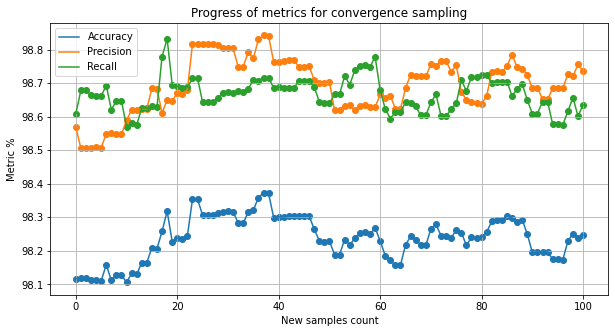

In [58]:
plt.figure(figsize= (10,5))

plt.plot(newSampleCount, acc, label = 'Accuracy')
plt.scatter(newSampleCount, acc)
plt.plot(newSampleCount, prec, label = 'Precision')
plt.scatter(newSampleCount, prec)
plt.plot(newSampleCount, rec, label = 'Recall')
plt.scatter(newSampleCount, rec)
plt.xlabel('New samples count')
plt.ylabel('Metric %')
plt.title('Progress of metrics for convergence sampling')
plt.grid()
plt.legend()
overallSamples = [sc+metricData.sampleCount[-1] for sc in newSampleCount]




Accuracy:  98.12% --> 98.25%
Precision: 98.57% --> 98.73%
Recall:    98.61% --> 98.64%
F1 score:  0.986  --> 0.987
F2 score:  98.601 --> 98.655 (beta = 2)


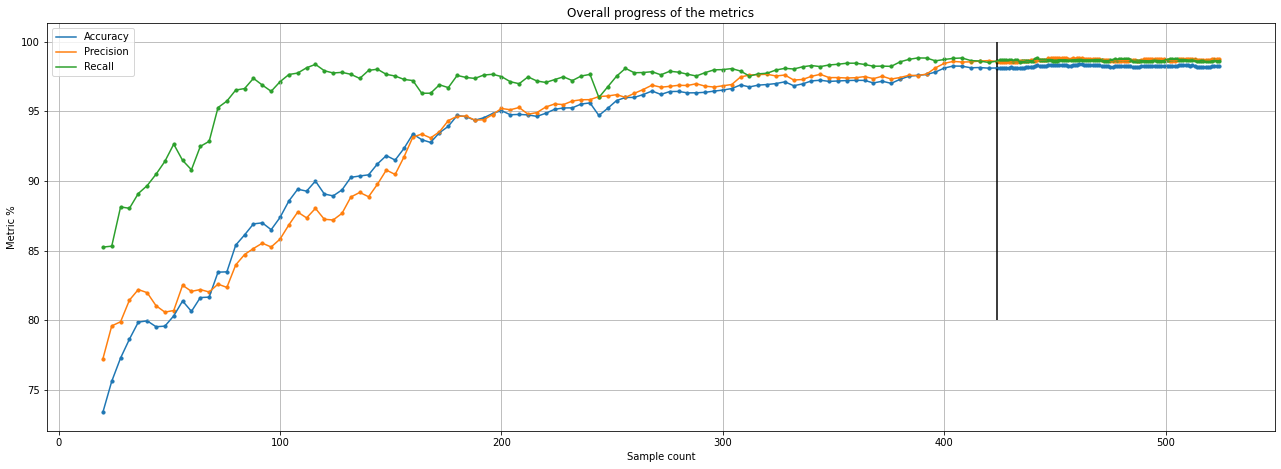

In [59]:
plt.figure(figsize= (22,7.5))
import copy 
pointSize = 10
pointColor = 'k'
oldAcc = copy.copy(metricData.acc[:-1])
oldPrec = copy.copy(metricData.precision[:-1])
oldRec = copy.copy(metricData.recall[:-1])
oldSampleCount = copy.copy(metricData.sampleCount[:-1])
oldAcc.extend(acc)
oldPrec.extend(prec)
oldRec.extend(rec)
oldSampleCount.extend(overallSamples)
plt.plot(oldSampleCount, oldAcc, label = 'Accuracy')
plt.plot(oldSampleCount, oldPrec, label = 'Precision')
plt.plot(oldSampleCount, oldRec, label = 'Recall')
plt.scatter(oldSampleCount, oldAcc, s = pointSize)
plt.scatter(oldSampleCount, oldPrec, s=pointSize)
plt.scatter(oldSampleCount, oldRec, s= pointSize)
plt.vlines(x = metricData.sampleCount[-1],ymin =80, ymax =100, color = pointColor)
plt.title('Overall progress of the metrics')
plt.xlabel('Sample count')
plt.ylabel('Metric %')
plt.grid()
plt.legend()


# Final values of the performance metrics:
print(f'Accuracy:  {metricData.acc[-1]:0.2f}% --> {oldAcc[-1]:0.2f}%')
print(f'Precision: {metricData.precision[-1]:0.2f}% --> {oldPrec[-1]:0.2f}%')
print(f'Recall:    {metricData.recall[-1]:0.2f}% --> {oldRec[-1]:0.2f}%')
f1ScoreInit = 2/(100/metricData.precision[-1] + 100/metricData.recall[-1])
f1ScoreFinal = 2/(100/oldPrec[-1] + 100/oldRec[-1])
print(f'F1 score:  {f1ScoreInit:0.3f}  --> {f1ScoreFinal:0.3f}')
beta = 2
fBetaInit = (1 + beta**2) * metricData.precision[-1]*metricData.recall[-1]/(beta**2 * metricData.precision[-1] + metricData.recall[-1])
fBetaFinal = (1+beta**2) * oldPrec[-1]*oldRec[-1]/(beta**2 * oldPrec[-1] + oldRec[-1])
print(f'F{beta} score:  {fBetaInit:0.3f} --> {fBetaFinal:0.3f} (beta = {beta})')

